In [1]:
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [2]:
%set_env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
tf.test.is_gpu_available()

True

In [4]:
tf.__version__

'1.15.0'

# Load data

In [5]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [6]:
test_labels = np.argmax(y_test, axis=1)
train_labels = np.argmax(y_train, axis=1)

# Train model

## pytorch

In [7]:
import torch
torch_X_train = torch.from_numpy(X_train.reshape(X_train.shape[0], 1, 28, 28)).type(torch.LongTensor)
torch_y_train = torch.from_numpy(train_labels).type(torch.LongTensor) # data type is long

torch_X_test = torch.from_numpy(X_test.reshape(X_test.shape[0], 1, 28, 28)).type(torch.LongTensor)
torch_y_test = torch.from_numpy(test_labels).type(torch.LongTensor) # data type is long

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

In [8]:
# data loader
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2)
        self.conv1_drop = nn.Dropout2d(0.3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=2)
        self.conv2_drop = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(1152, 10)
        self.conv3_drop = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv1_drop(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.conv2_drop(x)
        x = x.view(-1, 32 * 6 * 6)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)
net = Net()

In [10]:
from torch.autograd import Variable
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    EPOCHS = 10
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        tot = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            tot += len(predicted)
            #print(correct)
        print(predicted)
        print(correct)
        print('Epoch : {}, acc : {}'.format(epoch, correct.detach().numpy() / tot))
                
                
fit(net, train_loader)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2, 1, 8, 4, 6, 8, 7, 7, 0, 5, 2, 2, 6, 4, 8, 7, 0, 4, 0, 7, 7, 9, 5, 1,
        9, 6, 1, 2, 7, 3, 4, 9, 9, 6, 7, 9, 7, 1, 7, 2, 3, 7, 8, 5, 7, 6, 7, 1,
        9, 7, 2, 1, 8, 3, 4, 3, 0, 8, 3, 0, 4, 3, 7, 6, 0, 5, 6, 9, 3, 6, 3, 0,
        6, 0, 7, 1, 1, 3, 1, 3, 1, 6, 7, 4, 1, 7, 2, 7, 1, 5, 3, 9, 0, 7, 3, 2])
tensor(16838)
Epoch : 0, acc : 0.28063333333333335


KeyboardInterrupt: 

In [ ]:
for idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
    var_X_batch = Variable(X_test_batch).float()
    var_y_batch = Variable(y_test_batch) 
    preds = net(var_X_batch)
    print(preds, var_y_batch)
    break

## TF

In [7]:
load_mnist_model = False

In [8]:
filepath = './model_mnist/'  # change to directory where model is downloaded
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=2,
              batch_size=256,
              verbose=2,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model.h5'))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 - 8s - loss: 0.4905 - acc: 0.8446 - val_loss: 0.1223 - val_acc: 0.9652
Epoch 2/2
60000/60000 - 5s - loss: 0.1659 - acc: 0.9483 - val_loss: 0.0724 - val_acc: 0.9777


# Integrated gradients

In [18]:
n_steps = 50
method = "gausslegendre"
return_convergence_delta = True
return_predictions = False
ig  = IntegratedGradients(model,layer=model.layers[2],
                          n_steps=n_steps, 
                          method=method,
                          return_convergence_delta=return_convergence_delta, 
                          return_predictions=return_predictions)

In [19]:
nb_samples = 10
bs = 10
X_test_red = X_test[:nb_samples]
test_labels_red = test_labels[:nb_samples]

In [20]:
explanation = ig.explain(X_test_red, 
                         baselines=None, 
                         target=test_labels_red, 
                         internal_batch_size=bs)

In [21]:
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['tensorflow', 'keras'],
 'explanations': ['local', 'global'],
 'params': {'n_steps': 50,
  'method': 'gausslegendre',
  'return_convergence_delta': True,
  'return_predictions': False}}

In [22]:
attributions = explanation.data['attributions']

In [23]:
attributions.shape

(10, 14, 14, 64)

# Visualize attributions

In [20]:
i = 0

True label 7


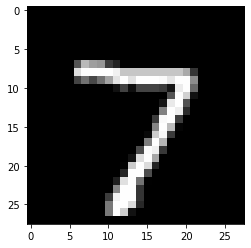

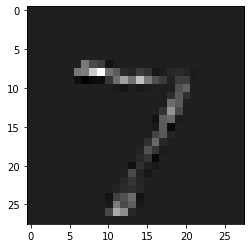

In [21]:
print('True label',test_labels[i])
plt.imshow(np.squeeze(X_test[i]), cmap='gray')
plt.show()
plt.imshow(np.squeeze(attributions[i]), cmap='gray')